# Maximum probability of loss

We are investing in two assets. Let $R_1$ and $R_2$ be the random variables corresponding to the returns. Both $R_1$ and $R_2$ have Gaussian marginal distributions, with known means $\mu_1=5$ and $\mu_2=15$ and known standard deviations $\sigma_1=3$ and $\sigma_2=10$. Moreover, we are given the correlation coefficient $\rho=-0.3$, i.e.,$$\mathbf{E} (R_1-\mu_1) (R_2-\mu_2)  = \rho \sigma_1 \sigma_2.$$

Use a linear programming solver to find the worst-case (maximum) probability of a loss, i.e, $p^\mathrm{loss} = \mathbf{Pr} (R_1+R_2 \leq 0)$. Compare the results to the case when $R_1$ and $R_2$ are jointly Gaussian.  Then,
  
  $$R_1+R_2 \sim \mathcal N(\mu_1+\mu_2,\sigma_1^2+\sigma_2^2+2 \rho \sigma_1\sigma_2),$$
  
  which for our parameters gives $p^\mathrm{loss} \approx 0.018$. 
  
This is an infinite-dimensional optimization problem, since you must maximize $p^\mathrm{loss}$ over an infinite-dimensional set of joint distributions. To (approximately) solve it, we discretize the values that $R_1$ and $R_2$ can take on, to $n=100$ values $r_1,\ldots, r_n$, uniformly spaced from $r_1=-20$ to $r_n=+50$. 
We use the discretized marginals $p^{(1)}$ and $p^{(2)}$ for $R_1$ and $R_2$, given by$$p^{(k)}_i =\mathbf{Pr}(R_k = r_i) =\frac{ \exp \left(-(r_i-\mu_k)^2/(2 \sigma_k^2) \right)}{\sum_{j=1}^n  \exp \left( -(r_j-\mu_k)^2/(2 \sigma_k^2) \right)},$$
  for $k=1,2$, $i=1, \ldots, n$.
  
  Plot the joint distribution that yields the maximum value of $p^\mathrm{loss}$ using e.g. ``matplotlib``'s ``contour`` (see the code below for two jointly Gaussian variables). Interpret what you see. 
  
  ---- 
*This exercise originates from "Additional Exercises" collection for Convex Optimization textbook of S. Boyd and L. Vandenberghe. Used under permission*

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
mu = (5, 15)
sigma = (3, 10)
rho = -0.3
n = 100
r=np.linspace(-20,50,n)

Below we create the marginals of the discrete distrubution

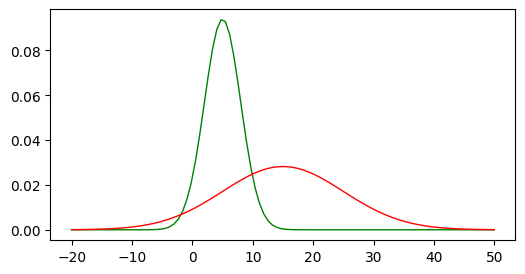

In [3]:
e = lambda k, i : math.exp(-(r[i]-mu[k])**2 / (2*sigma[k]**2))
p_mar = np.zeros((n,n))
for k in [0,1]:
    sum_exp = sum(e(k,i) for i in range(100))
    for i in range(n):
        p_mar[k][i] = e(k,i)/sum_exp

plt.rcParams['figure.figsize'] = [6, 3]
fig = plt.figure()
plt.plot(r,p_mar[0], 'g', linewidth=1)
plt.plot(r,p_mar[1], 'r', linewidth=1)

Let's also draw the joint Gaussian distribution, just for fun.

In [4]:
#calculate probability of loss
from scipy.stats import norm
norm.cdf(0, sum(mu), math.sqrt(sigma[0]**2 + sigma[1]**2 + 2*rho*sigma[0]*sigma[1]))

0.01801584310911677

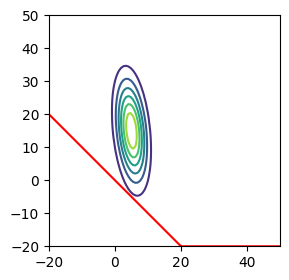

In [5]:
from scipy.stats import multivariate_normal

# Initializing the covariance matrix
cov = np.array([[sigma[0]**2, rho*sigma[0]*sigma[1]], [rho*sigma[0]*sigma[1], sigma[1]**2]])

# Generating a Gaussian bivariate distribution
# with given mean and covariance matrix
distr = multivariate_normal(cov = cov, mean = mu)

# Generating a meshgrid complacent with
# the 3-sigma boundary
X, Y = np.meshgrid(r,r)

# Generating the density function
# for each point in the meshgrid
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])

plt.axes().set_aspect('equal')
plt.contour(X, Y, pdf)
plt.plot(r,list(map(lambda x: max(x,-20), -r)),color="r") #R1+R2==0 red line


Above one can see that the two variables are indeed negatively correlated. 
The region below the red line is the loss event (we see that it is indeed unlikely)

### My Solution to the problem ###

### Step 1: We need to formulate the problem as an LP


Lets think of $P \in \mathbb{R}^{n \times n}_+$, as the joint probability matrix where element $P_{ij}$ is the probability that $R_1 = r_i$ and $R_2 = r_j$.

Our first constraint to the LP problem can be easily derived from this:
- The marginals must match the given distributions, so we set up the equations $PJ = p^{(1)}$ and $P^T J = p^{(2)}$, where $J$ is a vector of all ones.

Our second constraint can be given by the correlation between R1 and R2:
- We know that since R_1 and R_2 have a $\rho$ correlation factor between them, then $(r - \mu_{1})^T P (r - \mu_{2}) = \rho \sigma_1 \sigma_2$, where r represents the discretised and transformed vector values of the R1 and R2 variables. Technically we should use $r_1$ and $r_2$ but they share the same range so we can use the same vector.

Now finally we need to define our objective:
- We are being asked about the probability of a loss event where the sum $R_1 + R_2$ is less than or equal to zero. This probability is calculated by summing up all probabilities $P_{ij}$ for which $r_i + r_j \leq 0$. The expression for this is $\text{prob}(R_1 + R_2 \leq 0) = \sum_{r_i+r_j \leq 0} P_{ij}$.

Our goal now turns into an LP problem where we want to maximize $\sum_{r_i+r_j \leq 0} P_{ij}$ under the constraints that $P_{ij} \geq 0$ for all $i, j$, that the marginal distributions are maintained as given by $PJ = p^{(1)}$ and $P^T J = p^{(2)}$, and that the correlation matches the given parameters.

## Some interesting things that can be noted:
* Technically we can apply an extra constraint to P:
Since each element represents a probability, for any i,j it holds that $0 \le P_{ij} \le 1$
And actually I believe we can do even better than these limits.
* If $P_i$ and $P_j$ were uncorrelated: $\rho = 0$, then for each item $P_{ij}$ holds that $P_{ij}  == P_i * P_j$.
* Now that we know that they are correlated, and moreover with a negative correlation factor it holds that $P_{ij} \le P_i * P_j$.
* So technically if we calculate the product $P_i * P_j$ at the peak of the respective pdf's, we can limit each element of P to take at most that value.



In [144]:
# Imports #
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

In [145]:
# Constants #
mu1 = 5
mu2 = 15
sigma1 = 3
sigma2 = 10
rho = -0.3
n = 100
r_min = -20
r_max = 50

In [146]:
# Discretized outcomes for R1 and R2
r = np.linspace(r_min, r_max, n)

# Marginal distributions for R1 and R2
p1 = np.exp(-(r - mu1) ** 2 / (2 * sigma1 ** 2))
p1 /= np.sum(p1)

p2 = np.exp(-(r - mu2) ** 2 / (2 * sigma2 ** 2))
p2 /= np.sum(p2)

# Create the joint probability matrix P
P = cp.Variable((n, n), nonneg=True)

# Objective: Maximize probability of R1 + R2 <= 0
r1p = r[:, np.newaxis]
r2p = r[np.newaxis, :]
loss_mask = (r1p + r2p <= 0) * 1.0
objective = cp.Maximize(cp.sum(cp.multiply(P, loss_mask)))

diff_r1 = r - mu1
diff_r2 = r - mu2

# Constraints
# Constraints
constraints = [
    cp.sum(P, axis=0) == p2,
    cp.sum(P, axis=1) == p1,
    cp.matmul((cp.matmul(diff_r1.T, P)), diff_r2) == rho * sigma1 * sigma2
]

In [147]:
# Problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCS, verbose=True)

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Apr 22 02:04:12 AM: Your problem has 10000 variables, 3 constraints, and 0 parameters.
(CVXPY) Apr 22 02:04:12 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 22 02:04:12 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 22 02:04:12 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 22 02:04:12 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 22 02:04:12 AM: Compiling problem (target solver=SCS).
(C

0.09720567134669014